Thinking about the possibility of catching a disease, it is natural to divide the corresponding population heterogeneity into "social" and "biological" parts.

Same is true for the heterogeneity of spreading the disease. A person's ability to spread the disease depends on her social life (activity, frequency of being in crowded places, etc) and her "bioligical" properties like how often does she cough during illness. As for the latter, I do not currently see how to simulate the dymamics of heterogeneity of spreading in "biological" part. On the other hand, the non-trivial dynamics of the "social" part can be modeled on the assumption that "social" heterogeneity in the ability to catch the disease and "social" heterogeneity in the ability to spread the disease are controlled by the same factors and thus can be regarded as the identical heterogeneities.

Below I model the dynamic of "social" heterogeneity in the ability to catch and spread the disease togeter with the dynamic of "biological" heterogeneity in the ability to catch (but not spread) the disease for the SIR model.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scst
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.ticker as ticker
plt.rc('legend',fontsize=12, handlelength=2) # using a size in points

plt.style.use('seaborn-darkgrid')

For the beginning I repeat the SIR model with heterogenity of getting infected (HC SIR from now on) from previous part. HC SIR model heterogenity is described by lognormal distribution with initial (logarithmic) variance parameter $v_0$. HC SIR equations are
$$\begin{align}
& r_0= \alpha\, M(\mu,v), \\[3pt]
& \frac{d S}{dt}=- r_0 I\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu}{dt}=- r_0 I\,v, \\[3pt]
& \frac{d v}{dt}=-r_0 I\,v^2, \\[3pt]
&R = 1-S-I
\end{align}$$
$$I(0)=I_0,\:S(0)=1-I_0,\:\mu(0)=0,\:v(0)=v_0,\: \alpha=\frac{r_0(0)}{M(0,v_0)}$$ 
where $M(\mu,v)$ - expectation of lognormal variable
$M(\mu,v)=\exp(\mu+v/2)$

In [4]:
modeling_period=8.0
t_step=0.005
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)
n_steps=len(m_t)-1

def M(mu,v):return np.exp(mu+0.5*v)

Function to solve HC SIR equations is rather straightforward. It calculates $S$usceptible,$I$nfectious,$R$ecovered proportion values and also infection rate $|dS|$

In [5]:
def HC_SIR(r0,I0,v0):
    α=r0/M(0.0,v0)
    
    def ODE(y,t):
        S,I,mu,v=y

        minus_r0_mult_I=-α*M(mu,v)*I

        dS = minus_r0_mult_I*S
        dI = -dS - I
        dmu = minus_r0_mult_I*v
        dv = dmu*v
        return [dS, dI, dmu, dv]
    
    y0=[1.0-I0,I0,0.0,v0]
    
    sol = odeint(ODE,y0, m_t).T
    dS=-ODE(sol,m_t)[0]
    S,I,R=sol[0],sol[1],1.0-sol[0]-sol[1]
    return S,I,R,dS

In [ ]:
And now see the dynamics

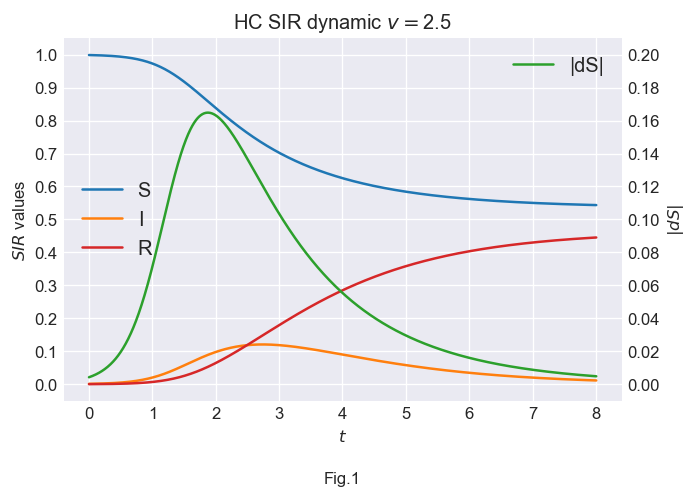

In [27]:
v0=2.5
r0=4.2
I0=0.001
S,I,R,dS= HC_SIR(r0,I0,v0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'S')
plt.plot(m_t, I,color='C1', label=f'I')
plt.plot(m_t, R,color='C3', label=f'R')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'|dS|') 
ax2.set_ylim([-0.01,0.21])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax2.grid(False)
ax2.set_ylabel(f'$|dS|$')
plt.legend(loc='upper right')
plt.title(f'HC SIR dynamic $v=${v0}')
ax.text(4,-.3, 'Fig.1', ha='center')



plt.show() 

First we describe (lognormally distributed) total heterohenity in ability of getting infected among susceptible population $H$ as a combination of "social" (denoted by $s$ subscript) and "biologial" (denoted by $b$ subscript) parts. This way previosly used the univariate lognormal distribution $H$ of scalar variable $h$ described by evolving parameters $\mu,v$ becomes a bivariate lognormal distribution of vector variable $\mathbf{h}=(h_s,h_b)$ described by evolving parameters $\mu_s,\mu_b,C,v_s,v_b$ and $h=h_s h_b$. Here C is the covariance of $\ln(h_s)$ and $\ln(h_b)$.  The joint probability density function for $h_s,h_b$ is:

$$
    f(h_s,h_b) =
      \frac{1}{2 \pi h_s h_b \sqrt{(1-\rho^2)v_s v_b}} \\
      \cdot\exp\left(
        -\frac{1}{(1-\rho^2)}\left[
          \frac{(\ln(h_s)-\mu_s)^2}{2v_s} +
          \frac{(\ln(h_b)-\mu_b)^2}{2v_b} -
          \frac{C(\ln(h_s)-\mu_s)(\ln(h_b)-\mu_b)}{v_s v_b}
        \right]
      \right)
$$

where $\rho^2=\frac{C^2}{v_s v_b}$ - the square of the (logarithmic) correlation coefficient.

Using reasoning similar to that in the previous part, and more complex mathematics, new equations are obtained that describe the dynamics of "social" and "biological" heterogeneity of the susceptible population ability to become infected. 
$$\begin{align}
& r_0= \alpha\, M(\mu_s,\mu_b,C,v_s,v_b), \\[3pt]
& \frac{d S}{dt}=- r_0 I\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu_s}{dt}=- r_0 I\,(C+v_s), \\[3pt]
& \frac{d\mu_b}{dt}=- r_0 I\,(C+v_b), \\[3pt]
& \frac{dC}{dt}=- r_0 I\,(C+v_s)\,(C+v_b), \\[3pt]
& \frac{d v_s}{dt}=-r_0 I\,(C+v_s)^2, \\[3pt]
& \frac{d v_b}{dt}=-r_0 I\,(C+v_b)^2, \\[3pt]
&R = 1-S-I 
\end{align}$$

$$I(0)=I_0,\:S(0)=1-I_0,\:\mu_s(0)=\mu_b(0)=C(0)=0 \\ v_s(0)+v_b(0)=v_0,\: \alpha=\frac{r_0(0)}{M(0,0,0,v_s,v_b)}$$ 
where $M(\mu_s,\mu_b,C,v_s,v_b)$ - expectation of bivariate lognormal variable
$M(\mu_s,\mu_b,C,v_s,v_b)=\exp(\mu_s+\mu_b+C+(v_s+v_b)/2)$

If we denote the sum $\mu_s+\mu_b$ as $\mu$ and $2C+v_s+v_b$ as $v$ we get exactly previos  HC SIR system.

In [11]:
def HC_SIR2(r0,I0,vs,vb):
    α=r0/M(0.0,vs+vb)
    
    def ODE(y,t):
        S,I,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_r0_mult_I=-α*M(mus+mub,Cpvs+Cpvb)*I

        dS = minus_r0_mult_I*S
        dI = -dS - I
        dmus = minus_r0_mult_I*Cpvs
        dmub = minus_r0_mult_I*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI, dmus,dmub,dC,dvs,dvb]
    
    y0=[1.0-I0,I0,0.0,0.0,0.0,vs,vb]
    
    sol = odeint(ODE,y0, m_t).T
    dS=-ODE(sol,m_t)[0]
    S,I,R=sol[0],sol[1],1.0-sol[0]-sol[1]
    C=sol[-3]
    v_s=sol[-2]
    v_b=sol[-1]
    return S,I,R,dS,C,v_s,v_b

And the result is

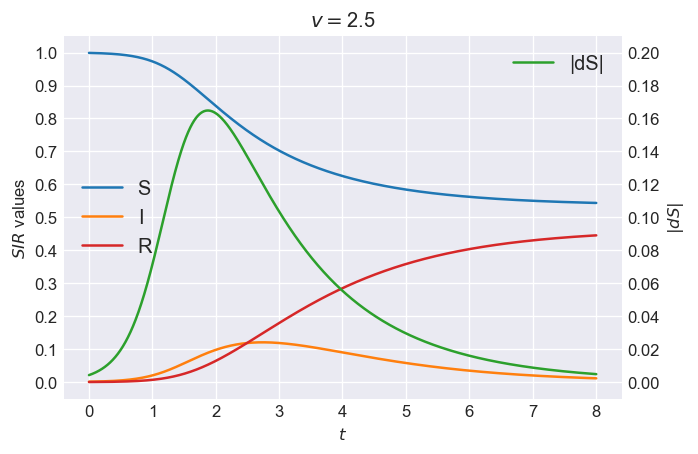

In [25]:
vs0=1.0
vb0=v0-vs0
S,I,R,dS,C,vs,vb= HC_SIR2(r0,I0,vs0,vb0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'S')
plt.plot(m_t, I,color='C1', label=f'I')
plt.plot(m_t, R,color='C3', label=f'R')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'|dS|') 
ax2.set_ylim([-0.01,0.21])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax2.grid(False)
ax2.set_ylabel(f'$|dS|$')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}')

plt.show() 

Exactly the same as in fig. 1, but we can see relative dynamic of social and biological heterogeneity

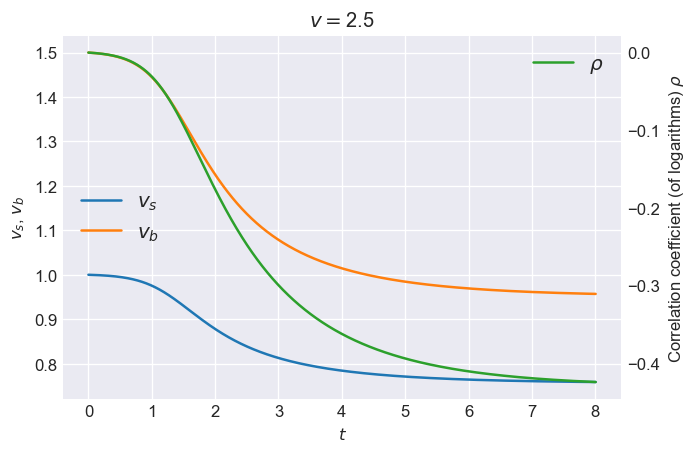

In [30]:
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, vs, color='C0', label=f'$v_s$')
plt.plot(m_t, vb,color='C1', label=f'$v_b$')
#ax.set_ylim([-0.05,1.05])
#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$v_s$, $v_b$')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, C/np.sqrt(vs*vb), color='C2', label=f'$ρ$') 
#ax2.set_ylim([-0.01,0.21])
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax2.grid(False)
ax2.set_ylabel(f'Correlation coefficient (of logarithms) $ρ$')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}')

plt.show() 

It is interesting to note that social and biological heterogeneity becomes more and more anti-correlated over time. And this is logical. So, a person with a high social ability to pick up a disease can remain uninfected for a long time only if his biological ability to become infected is low and vice versa. Thus, as time goes on the distribution of social and biological ability to become infected among still non-infected people should become more anti-correlated.

If a person with a high social ability to pick up a disease becomes infected, then he, at least for some time, becomes a person with a high social ability to spread the disease. Thus, the social ability to become infected and spread disease flows from the uninfected to the infected as the infection progresses. A decrease in the total social ability to get infected among the susceptible part of the population is accompanied by a similar increase (among the infected part of the population) in the total social ability to infect. 

Total social ability to get infected among the susceptible part of the population is a product of everage social ability to get infected among the susceptible part of the population $M_s=M(\mu_s,v_s)=\exp(mu_s+v_s/2)$ and a portion of susceptible population - $S$. So if we denote as $A$ (from activity) the total social ability to infect we get for its dynamic inflow term
$$\frac{dA}{dt}=-\frac{d(M_s S)}{dt}- \text{[outflow term]}$$

For some time we will not worry about the decay of a person's social ability to infect as the disease progresses, and we will assume that this decay does not affect the heterogeneity of the distribution, and is taken into account by multiplying by the corresponding constant. The decay can be more correctly handled, say, by dividing the infected part of the population $I$ into not yet having serious symptoms and spreading the disease with the full extent of their social activity $I_l$ and having already reduced social activity due to the manifestation of symptoms $I_h$.

Let's get down to $A$ outflow term. The total social ability to infect reduces as long as infected persons recovered. The population outflow from infected to recovered is described by second term in the right side of the equation:
$$\frac{dI}{dt} =- \frac{dS}{dt}- I$$
Each convalescent takes with him a corresponding portion of the social capacity to infect. Since the order of recovery does not necessarily coincide with the order of illness, we assume that the total share of the social ability to infect taken away by the recovering is simply the product of the average social ability to infect by the number of recoveries. Everage average social ability to infect is $a=A/I$ the recoveries outflow is $I$, so outflow term we are looking for is $a\cdot I=A$. That means
$$\frac{dA}{dt}=-\frac{d(M_s S)}{dt}- A$$

Now let's take a closer look at the equation
$$\frac{d S}{dt}=- r_0 I\,S$$

It describes the fact that infectious agents infect susceptible individuals at an intensity determined by the coefficient $r_0$. This coefficient should be equal, up to some constant, to the product of the average ability to get infected -$M$ and the average ability to spread the infection - $a$:

$$r_0=\alpha M a$$

and susceptible part dynamics is given by:
$$\frac{d S}{dt}=- \alpha M\, a\, I\,S=- \alpha M \frac{A}{I} I\,S=- \alpha M\, A\,S$$

As a result we get the system:
$$\begin{align}
& M =  \exp(\mu_s+\mu_b+C+(v_s+v_b)/2), \\[3pt]
& M_s =  \exp(\mu_s+v_s/2), \\[3pt]
& \frac{d S}{dt}=- \alpha M A\,S, \\[3pt]
& \frac{dA}{dt} =- \frac{d(M_s S)}{dt}- A,\\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu_s}{dt}=- \alpha M A\,(C+v_s), \\[3pt]
& \frac{d\mu_b}{dt}=- \alpha M A\,(C+v_b), \\[3pt]
& \frac{dC}{dt}=- \alpha M A\,(C+v_s)\,(C+v_b), \\[3pt]
& \frac{d v_s}{dt}=-\alpha M A\,(C+v_s)^2, \\[3pt]
& \frac{d v_b}{dt}=-\alpha M A\,(C+v_b)^2, \\[3pt]
&R = 1-S-I 
\end{align}$$

Don't be afraid of the system size, the system can be made much shorter by some substitutions, but the meaning of new variables will be quite opaque.